# Ordinal Logit/Proportional Odds Model

##### Model Summary:
An ordered logistic regression model is used when the outcome variable is categorical, and the order of those categories matter. For example, this model may be used to investigate what factors contribute to a customer feeling Unsatisfied, Netural, or Satisfied toward a product, or determine if a movie is likely to receive a 1-5 score on a 5-star rating system.

##### Dataset:
The IBM HR Analytics Employee Attrition & Performance dataset can be found at https://www.kaggle.com/datasets/pavansubhasht/ibm-hr-analytics-attrition-datase. The site also includes a data dictionary.

##### Problem Statement:
Due to changes in the job market, IBM wants to conduct an analysis to help them better retain their existing employees. The Human Resources team has asked you to identify trends between employees and their job satisfaction level.

In [1]:
# import packages
#!pip install pandas
import pandas as pd
from pandas.api.types import CategoricalDtype
import os
import numpy as np

# stats packages 
import scipy.stats as stats
#!pip install statsmodels
import statsmodels.stats.api as sms
from scipy.stats import normaltest # uses D’Agostino test for normality
from scipy.stats import wilcoxon
from statsmodels.miscmodels.ordinal_model import OrderedModel # https://www.statsmodels.org/dev/generated/statsmodels.miscmodels.ordinal_model.OrderedModel.html

# sklearn 
#!pip install scikit-learn
#import scikit-learn as sklearn
# from sklearn.model_selection import train_test_split

# data viz
!pip install --upgrade matplotlib 
import matplotlib.pyplot as plt
#!pip install seaborn
import seaborn as sns

os.getcwd()

Requirement already up-to-date: matplotlib in c:\users\18594\anaconda3\lib\site-packages (3.5.3)


'C:\\Users\\18594\\Ordered_Logit_Propotional_Odds_Model'

### Import Data and Exploratory Data Analysis

In [2]:
# import data
df = pd.read_csv('C:\\Users\\18594\\Ordered_Logit_Propotional_Odds_Model\\HR_Employee_Attrition.csv')

# Since we are only looking at studying current employees, you will want to filter the data down to where Attrition=0
df = df.loc[df['Attrition'] == 'No']

# Creat numerical representation of the the following categorical variables
df['isFemale'] = np.where(df['Gender']=='Female',1,0) # 1 = female; 0 = male
df['OverTime_Binary'] = np.where(df['OverTime']=='Yes',1,0) # 1 = ye - works over time; 0 = no - does not work over time

# preview data
print("Shape of data frame is:",df.shape)
df.head()

Shape of data frame is: (1233, 37)


Age Attrition     BusinessTravel  DailyRate              Department  \
1   49        No  Travel_Frequently        279  Research & Development   
3   33        No  Travel_Frequently       1392  Research & Development   
4   27        No      Travel_Rarely        591  Research & Development   
5   32        No  Travel_Frequently       1005  Research & Development   
6   59        No      Travel_Rarely       1324  Research & Development   

   DistanceFromHome  Education EducationField  EmployeeCount  EmployeeNumber  \
1                 8          1  Life Sciences              1               2   
3                 3          4  Life Sciences              1               5   
4                 2          1        Medical              1               7   
5                 2          2  Life Sciences              1               8   
6                 3          3        Medical              1              10   

   ...  StockOptionLevel TotalWorkingYears  TrainingTimesLastYear  \
1  ...                 1                10                      3   
3  ...                 0                 8                      3   
4  ...                 1                 6                      3   
5  ...                 0                 8                      2   
6  ...                 3                12                      3   

   WorkLifeBalance  YearsAtCompany YearsInCurrentRole  \
1                3              10                  7   
3                3               8                  7   
4                3               2                  2   
5                2               7                  7   
6                2               1                  0   

   YearsSinceLastPromotion YearsWithCurrManager  isFemale  OverTime_Binary  
1                        1                    7         0                0  
3                        3                    0         1                1  
4                        2                    2         0                0  
5                        3                    6         0                0  
6                        0                    0         1                1  

[5 rows x 37 columns]

In [3]:
# check data types
df.dtypes

Age                          int64
Attrition                   object
BusinessTravel              object
DailyRate                    int64
Department                  object
DistanceFromHome             int64
Education                    int64
EducationField              object
EmployeeCount                int64
EmployeeNumber               int64
EnvironmentSatisfaction      int64
Gender                      object
HourlyRate                   int64
JobInvolvement               int64
JobLevel                     int64
JobRole                     object
JobSatisfaction              int64
MaritalStatus               object
MonthlyIncome                int64
MonthlyRate                  int64
NumCompaniesWorked           int64
Over18                      object
OverTime                    object
PercentSalaryHike            int64
PerformanceRating            int64
RelationshipSatisfaction     int64
StandardHours                int64
StockOptionLevel             int64
TotalWorkingYears   

In [4]:
# print descriptive statistics
df.describe()

Age    DailyRate  DistanceFromHome    Education  EmployeeCount  \
count  1233.000000  1233.000000       1233.000000  1233.000000         1233.0   
mean     37.561233   812.504461          8.915653     2.927007            1.0   
std       8.888360   403.208379          8.012633     1.027002            0.0   
min      18.000000   102.000000          1.000000     1.000000            1.0   
25%      31.000000   477.000000          2.000000     2.000000            1.0   
50%      36.000000   817.000000          7.000000     3.000000            1.0   
75%      43.000000  1176.000000         13.000000     4.000000            1.0   
max      60.000000  1499.000000         29.000000     5.000000            1.0   

       EmployeeNumber  EnvironmentSatisfaction   HourlyRate  JobInvolvement  \
count     1233.000000              1233.000000  1233.000000     1233.000000   
mean      1027.656123                 2.771290    65.952149        2.770479   
std        606.217074                 1.071132    20.380754        0.692050   
min          2.000000                 1.000000    30.000000        1.000000   
25%        483.000000                 2.000000    48.000000        2.000000   
50%       1022.000000                 3.000000    66.000000        3.000000   
75%       1574.000000                 4.000000    83.000000        3.000000   
max       2068.000000                 4.000000   100.000000        4.000000   

          JobLevel  ...  StockOptionLevel  TotalWorkingYears  \
count  1233.000000  ...       1233.000000        1233.000000   
mean      2.145985  ...          0.845093          11.862936   
std       1.117933  ...          0.841985           7.760719   
min       1.000000  ...          0.000000           0.000000   
25%       1.000000  ...          0.000000           6.000000   
50%       2.000000  ...          1.000000          10.000000   
75%       3.000000  ...          1.000000          16.000000   
max       5.000000  ...          3.000000          38.000000   

       TrainingTimesLastYear  WorkLifeBalance  YearsAtCompany  \
count            1233.000000      1233.000000     1233.000000   
mean                2.832928         2.781022        7.369019   
std                 1.293585         0.681907        6.096298   
min                 0.000000         1.000000        0.000000   
25%                 2.000000         2.000000        3.000000   
50%                 3.000000         3.000000        6.000000   
75%                 3.000000         3.000000       10.000000   
max                 6.000000         4.000000       37.000000   

       YearsInCurrentRole  YearsSinceLastPromotion  YearsWithCurrManager  \
count         1233.000000              1233.000000           1233.000000   
mean             4.484185                 2.234388              4.367397   
std              3.649402                 3.234762              3.594116   
min              0.000000                 0.000000              0.000000   
25%              2.000000                 0.000000              2.000000   
50%              3.000000                 1.000000              3.000000   
75%              7.000000                 3.000000              7.000000   
max             18.000000                15.000000             17.000000   

          isFemale  OverTime_Binary  
count  1233.000000      1233.000000  
mean      0.406326         0.234388  
std       0.491346         0.423787  
min       0.000000         0.000000  
25%       0.000000         0.000000  
50%       0.000000         0.000000  
75%       1.000000         0.000000  
max       1.000000         1.000000  

[8 rows x 28 columns]

In [5]:
# use df.info() to identify any missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1233 entries, 1 to 1469
Data columns (total 37 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1233 non-null   int64 
 1   Attrition                 1233 non-null   object
 2   BusinessTravel            1233 non-null   object
 3   DailyRate                 1233 non-null   int64 
 4   Department                1233 non-null   object
 5   DistanceFromHome          1233 non-null   int64 
 6   Education                 1233 non-null   int64 
 7   EducationField            1233 non-null   object
 8   EmployeeCount             1233 non-null   int64 
 9   EmployeeNumber            1233 non-null   int64 
 10  EnvironmentSatisfaction   1233 non-null   int64 
 11  Gender                    1233 non-null   object
 12  HourlyRate                1233 non-null   int64 
 13  JobInvolvement            1233 non-null   int64 
 14  JobLevel                

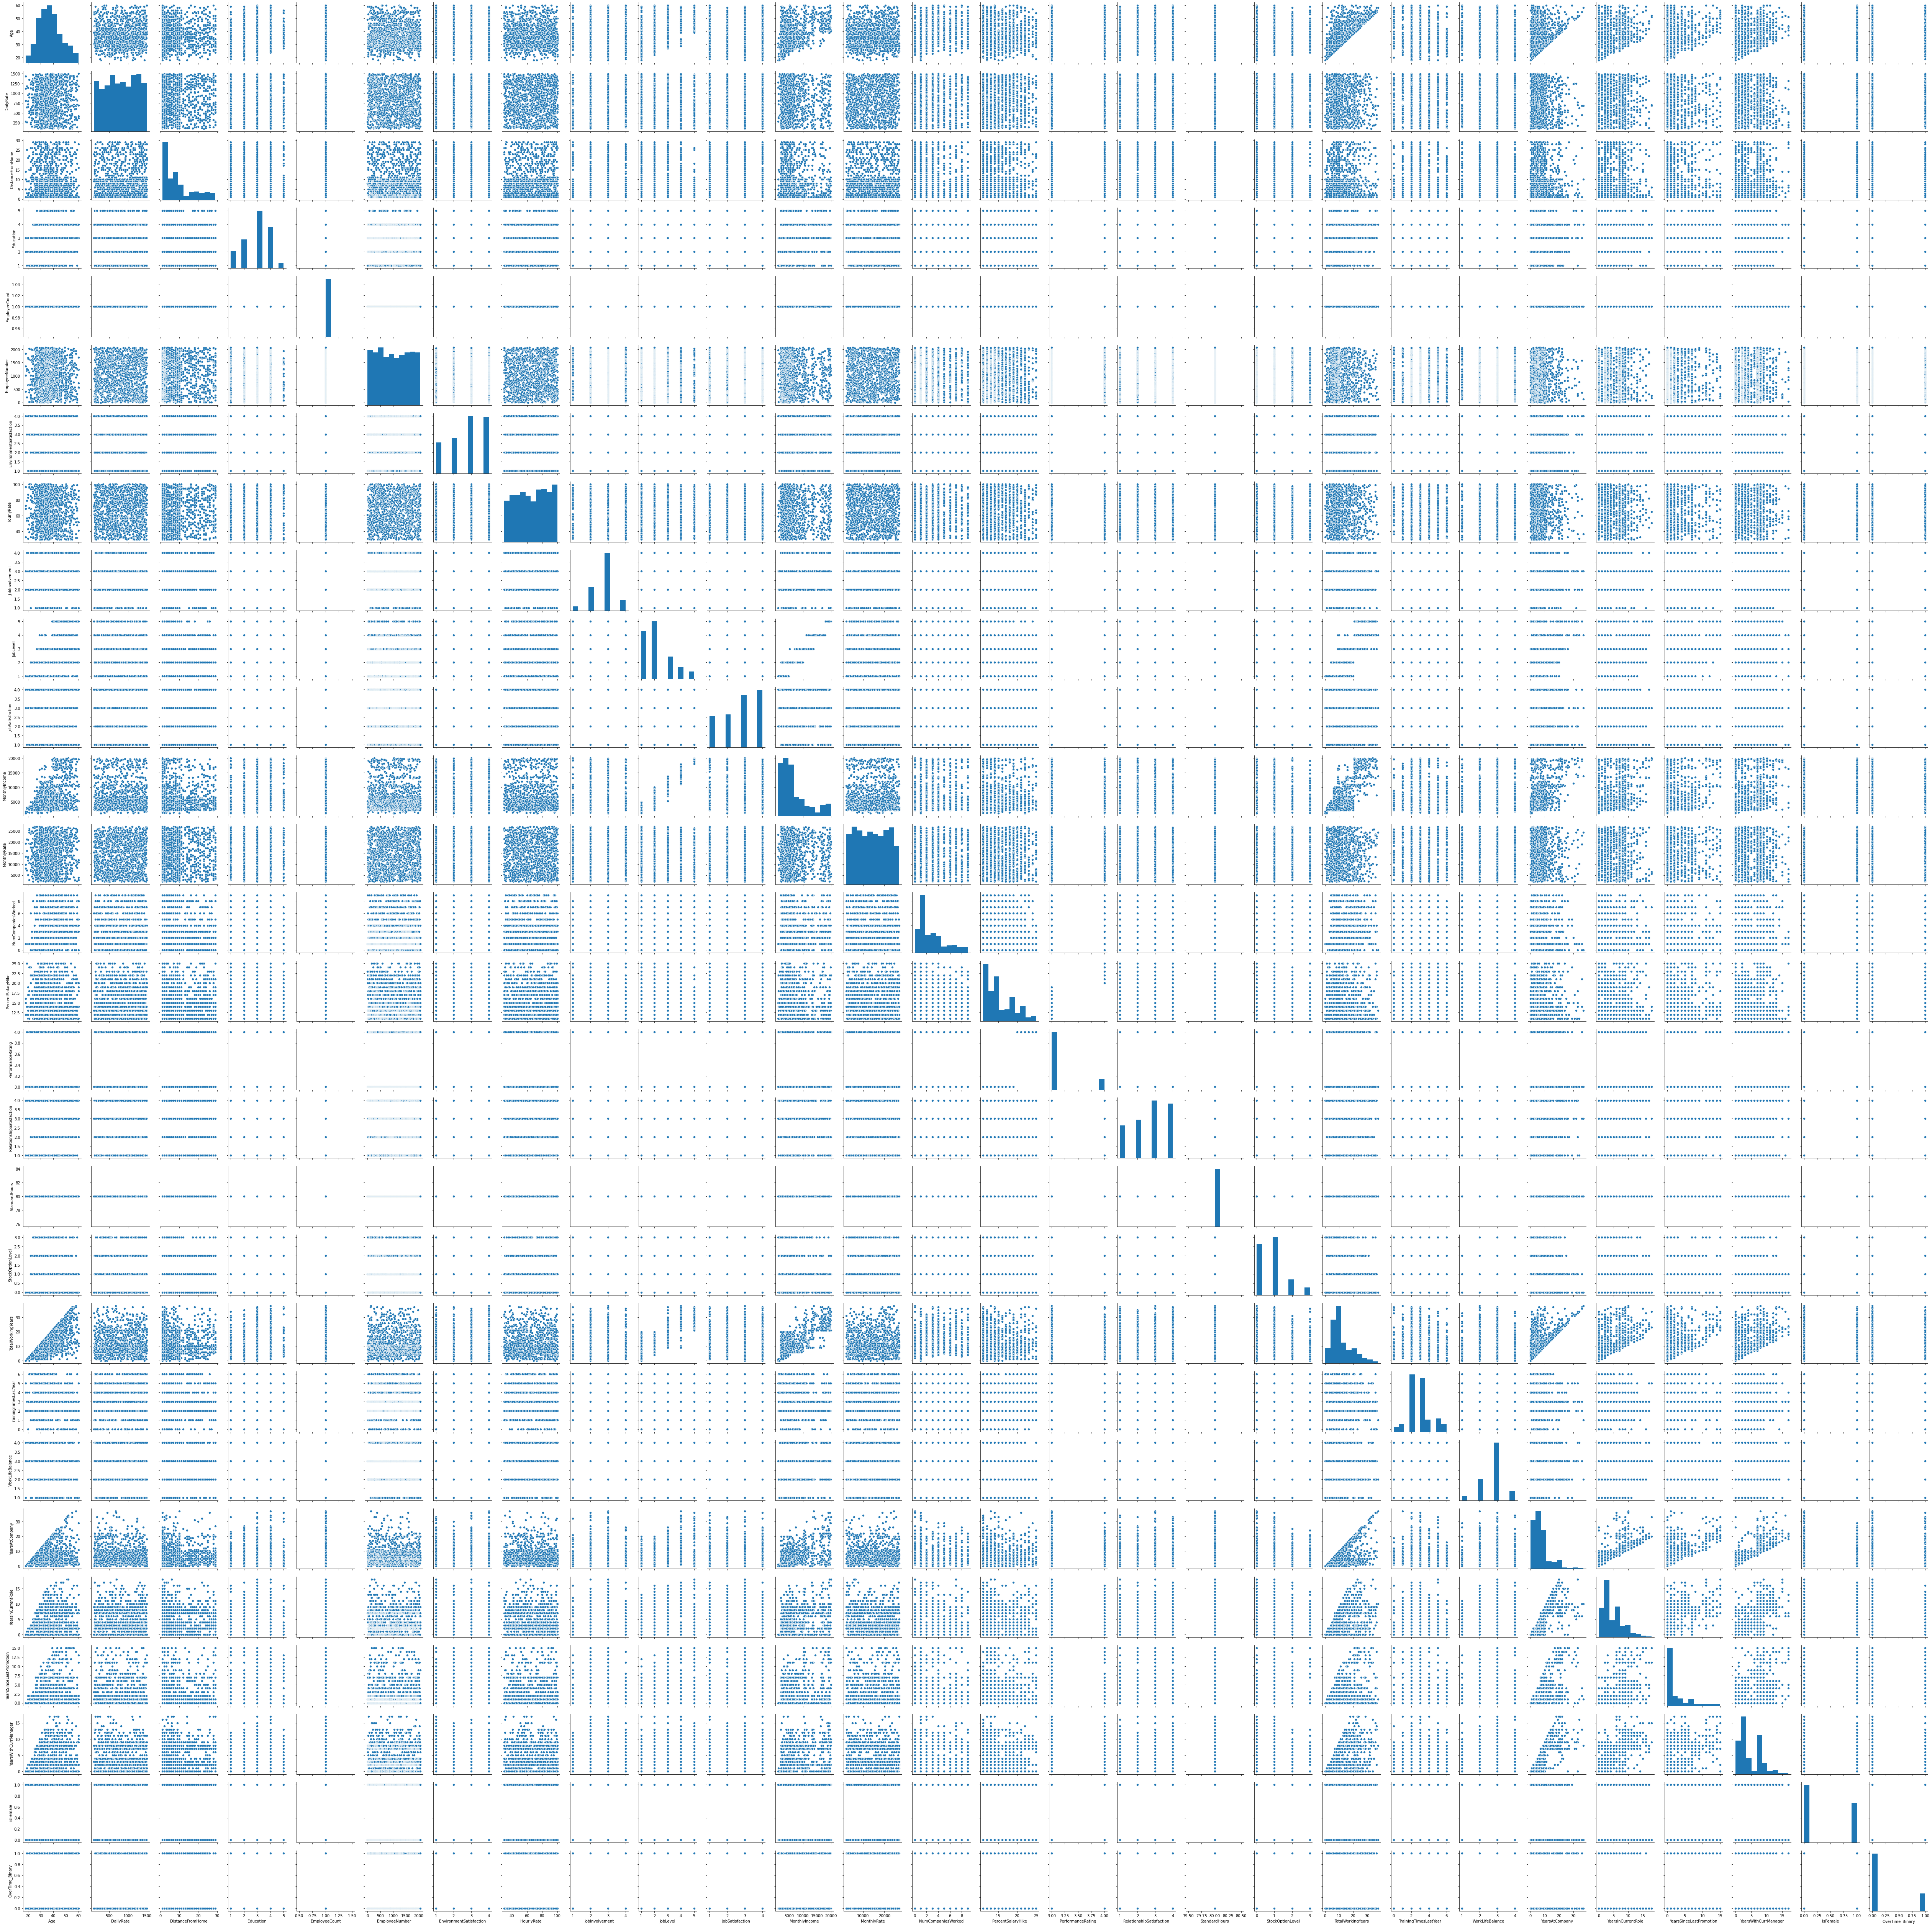

In [6]:
# plot relationships that variables have to each other
# https://www.webagesolutions.com/blog/data-visualization-and-eda-with-pandas-and-seaborn
# NOTE: double click on the output below to make the plots larger, or consider saving the output as a PNG file
sns.pairplot(df)

In [10]:
# # now, show how the variables relate to each other with respect to JobSatisfaction rating
# # https://www.webagesolutions.com/blog/data-visualization-and-eda-with-pandas-and-seaborn
# sns.pairplot(df,hue='JobSatisfaction') # also double click or save as PNG to enlarge

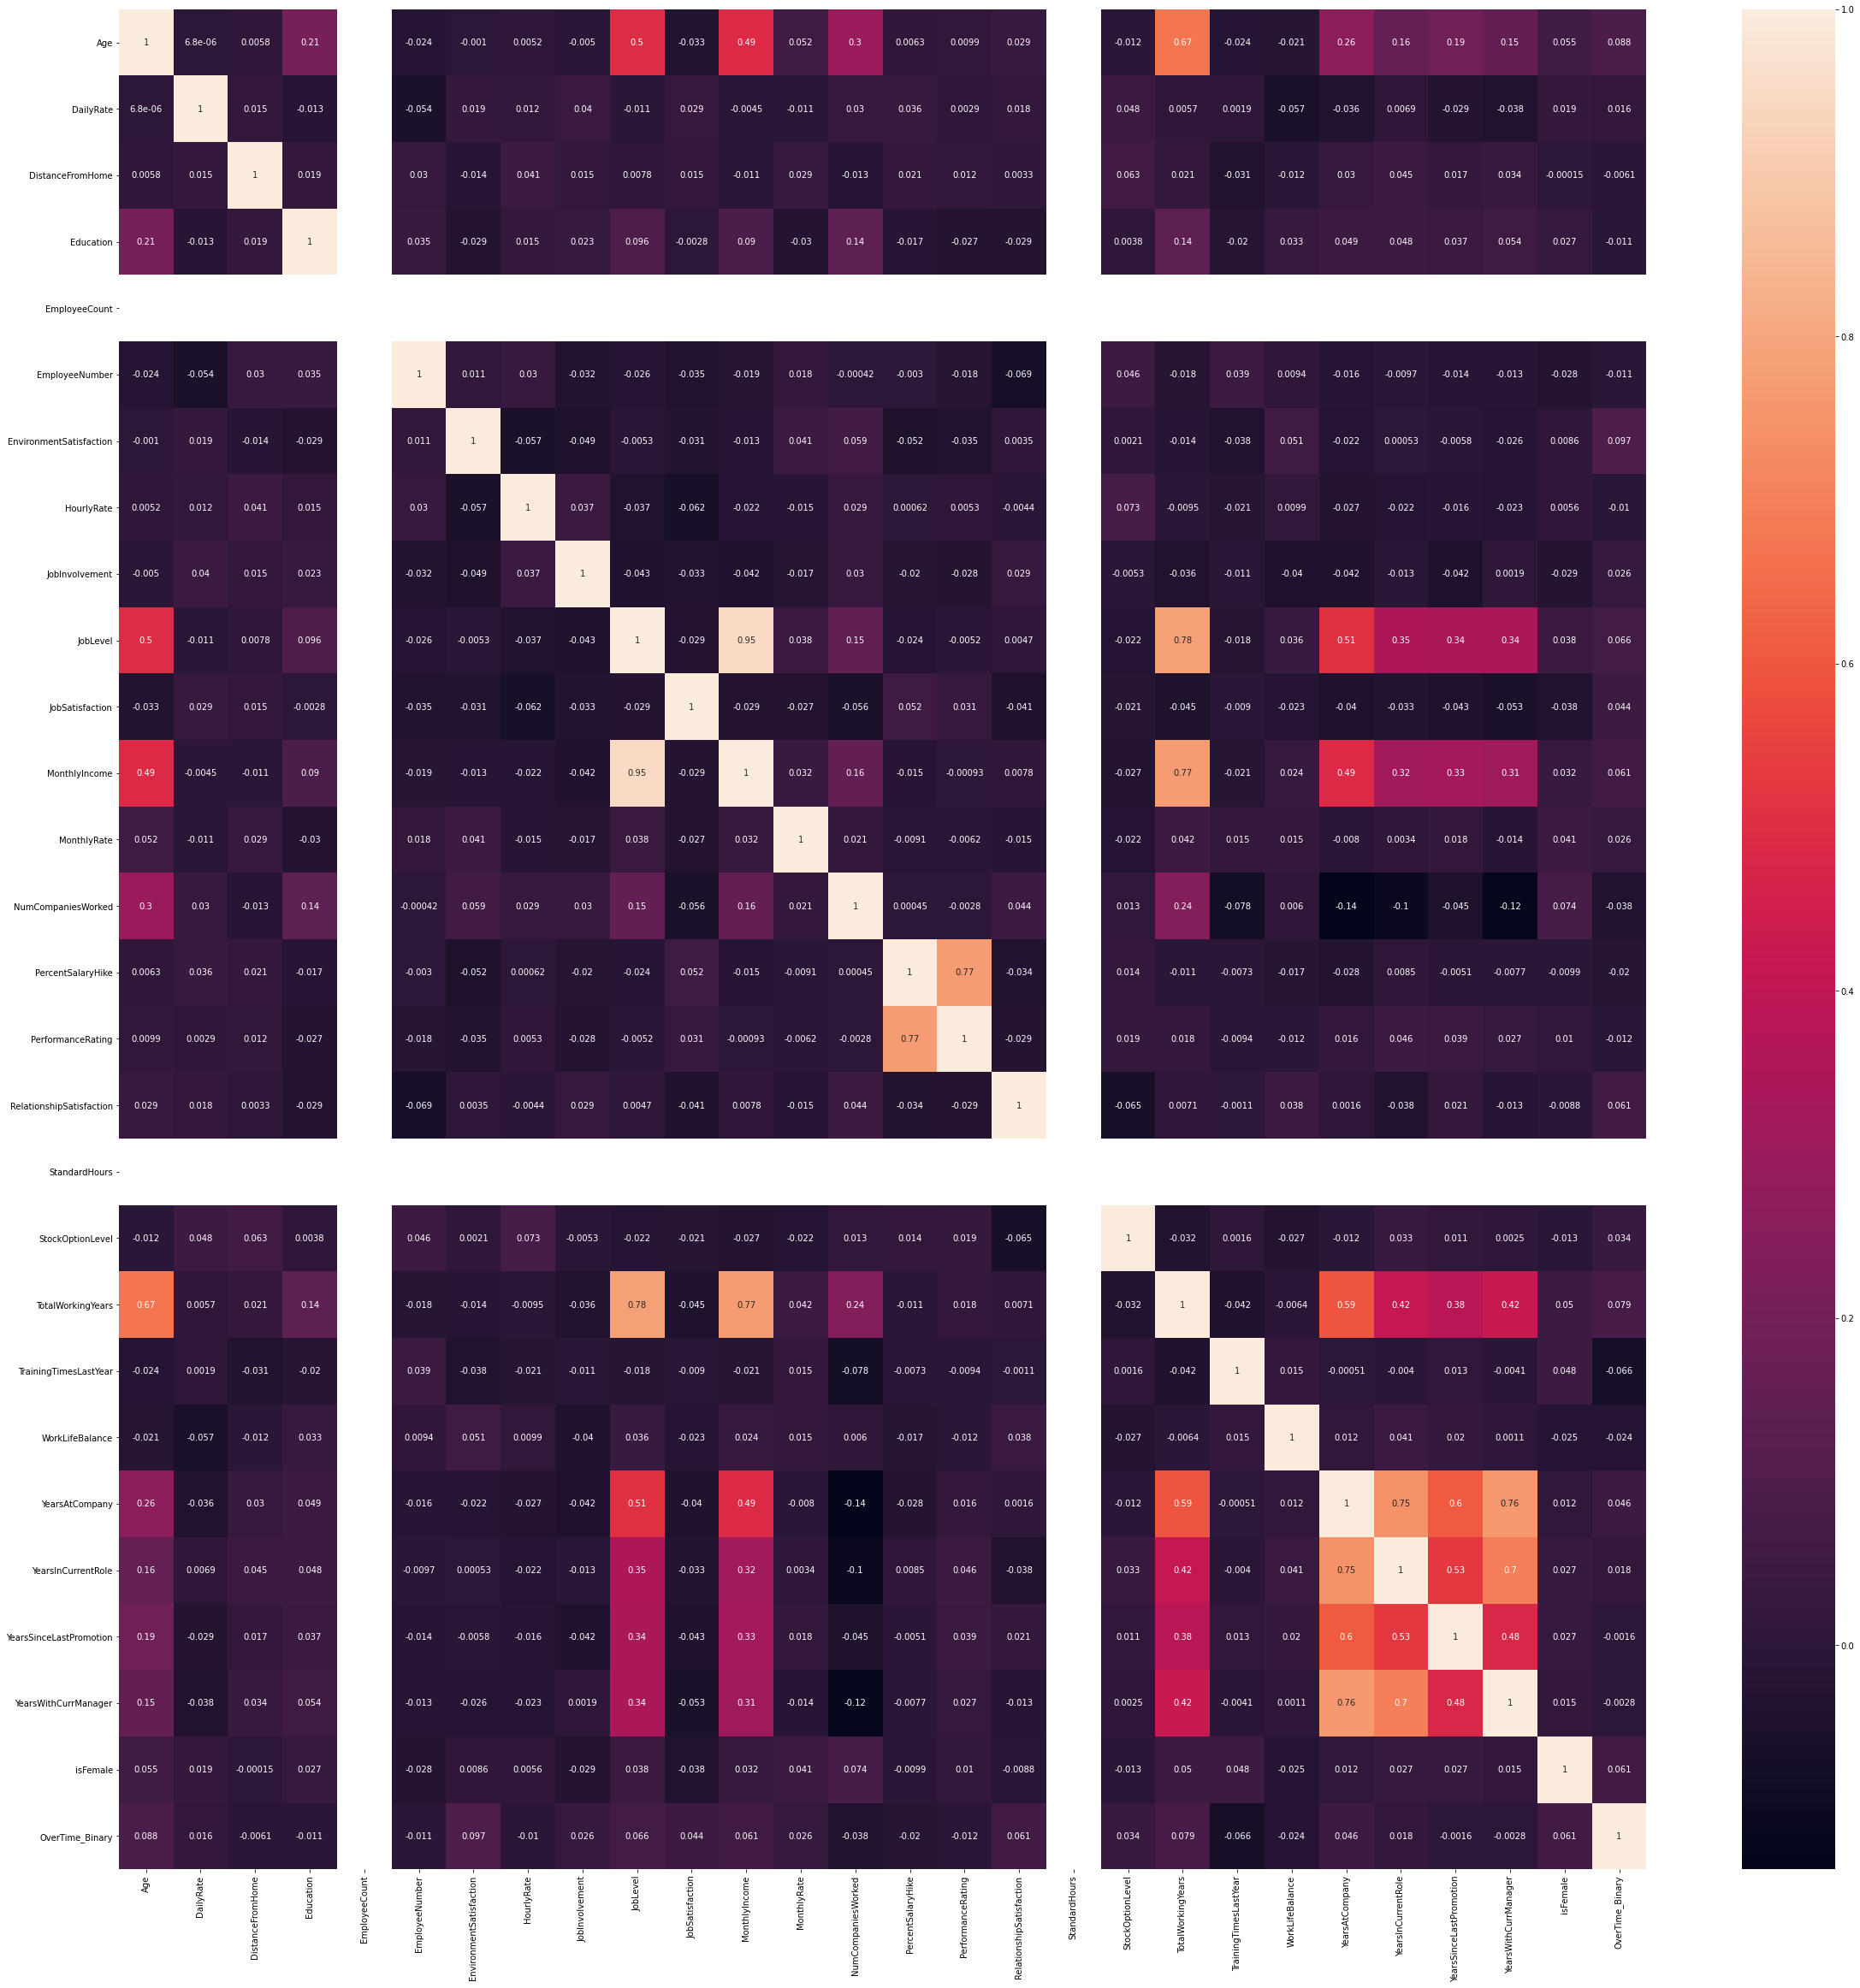

In [11]:
# see which fields may be highly correlated with job satisfaction
corr_matrix = df.corr()
plt.figure(figsize = (40,40)) # set size of heatmap
sns.heatmap(corr_matrix, annot=True)
plt.show()

In [12]:
#Plot correlation matrix in a table view (same as above but sometimes is a little more readable)
df.corr()

Age  DailyRate  DistanceFromHome  Education  \
Age                       1.000000   0.000007          0.005828   0.208739   
DailyRate                 0.000007   1.000000          0.015425  -0.013103   
DistanceFromHome          0.005828   0.015425          1.000000   0.019373   
Education                 0.208739  -0.013103          0.019373   1.000000   
EmployeeCount                  NaN        NaN               NaN        NaN   
EmployeeNumber           -0.024071  -0.053613          0.029550   0.034885   
EnvironmentSatisfaction  -0.001000   0.019345         -0.014166  -0.029207   
HourlyRate                0.005158   0.012215          0.040857   0.015267   
JobInvolvement           -0.005037   0.040008          0.014510   0.023233   
JobLevel                  0.497797  -0.010678          0.007809   0.095539   
JobSatisfaction          -0.033143   0.028742          0.015008  -0.002839   
MonthlyIncome             0.486713  -0.004482         -0.011321   0.089564   
MonthlyRate               0.052284  -0.011258          0.028762  -0.029642   
NumCompaniesWorked        0.301987   0.030215         -0.013295   0.142676   
PercentSalaryHike         0.006324   0.035506          0.021266  -0.016764   
PerformanceRating         0.009863   0.002914          0.011508  -0.026763   
RelationshipSatisfaction  0.028981   0.018157          0.003340  -0.029458   
StandardHours                  NaN        NaN               NaN        NaN   
StockOptionLevel         -0.012452   0.048172          0.062549   0.003809   
TotalWorkingYears         0.672753   0.005735          0.020947   0.140810   
TrainingTimesLastYear    -0.024100   0.001945         -0.030805  -0.020184   
WorkLifeBalance          -0.021222  -0.057386         -0.012445   0.032791   
YearsAtCompany            0.264745  -0.036447          0.029983   0.048644   
YearsInCurrentRole        0.158121   0.006929          0.044839   0.047987   
YearsSinceLastPromotion   0.190892  -0.029210          0.016516   0.037161   
YearsWithCurrManager      0.154146  -0.038031          0.033575   0.053890   
isFemale                  0.055353   0.018688         -0.000153   0.026652   
OverTime_Binary           0.087661   0.016266         -0.006125  -0.011013   

                          EmployeeCount  EmployeeNumber  \
Age                                 NaN       -0.024071   
DailyRate                           NaN       -0.053613   
DistanceFromHome                    NaN        0.029550   
Education                           NaN        0.034885   
EmployeeCount                       NaN             NaN   
EmployeeNumber                      NaN        1.000000   
EnvironmentSatisfaction             NaN        0.010649   
HourlyRate                          NaN        0.029795   
JobInvolvement                      NaN       -0.031568   
JobLevel                            NaN       -0.025655   
JobSatisfaction                     NaN       -0.035435   
MonthlyIncome                       NaN       -0.019142   
MonthlyRate                         NaN        0.017864   
NumCompaniesWorked                  NaN       -0.000421   
PercentSalaryHike                   NaN       -0.003038   
PerformanceRating                   NaN       -0.017799   
RelationshipSatisfaction            NaN       -0.068836   
StandardHours                       NaN             NaN   
StockOptionLevel                    NaN        0.045845   
TotalWorkingYears                   NaN       -0.018282   
TrainingTimesLastYear               NaN        0.038853   
WorkLifeBalance                     NaN        0.009447   
YearsAtCompany                      NaN       -0.016292   
YearsInCurrentRole                  NaN       -0.009714   
YearsSinceLastPromotion             NaN       -0.013578   
YearsWithCurrManager                NaN       -0.013258   
isFemale                            NaN       -0.028100   
OverTime_Binary                     NaN       -0.010668   

                          EnvironmentSatisfaction  Hourl

##### In this dataset, employees rank their JobSatisfaction is based on the following statements:

1. Low
2. Medium
3. High
4. Very High

In [13]:
# Define Satisfaction categories as ordered categorical data dtypes from highly dissatisfied (1) being lowest rank to highly satisfied (4) being the highest rank
# https://analyticsindiamag.com/a-complete-tutorial-on-ordinal-regression-in-python/
cat_type_ordered = CategoricalDtype(categories=[1,2,3,4], ordered=True)
df["JobSatisfaction"] = df["JobSatisfaction"].astype(cat_type_ordered)
df["RelationshipSatisfaction"] = df["RelationshipSatisfaction"].astype(cat_type_ordered)
df["EnvironmentSatisfaction"] = df["EnvironmentSatisfaction"].astype(cat_type_ordered)

# identify binary categorical variables as a non-ordered categorical variable
# note ordered = False parameter that tells us that in these order does not matter
cat_type_non_ordered = CategoricalDtype(categories=[0,1], ordered=False)
df['isFemale'] = df['isFemale'].astype(cat_type_non_ordered)
df['OverTime_Binary'] = df['OverTime_Binary'].astype(cat_type_non_ordered)

# convert other dtypes as needed
# df.info() # confirm data type changes

As we plot the spread of JobSatisfaction, it seems most people are satisfied overall in their role - this is great news for us! But, there are a considerable number of employees who have a job satisfaction rating of 1 or 2. These may be at a heightened risk of leaving the company, so we want to dive deeper.


Text(0.5, 1.0, 'Score Distribution')

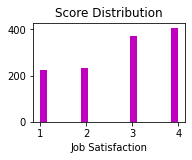

In [14]:
plt.subplot(222)
plt.hist(df['JobSatisfaction'],bins=20,color='m')
plt.xlabel('Job Satisfaction')
plt.title('Score Distribution')

In [15]:
# Number of people who provided each response
df['JobSatisfaction'].value_counts()

4    407
3    369
2    234
1    223
Name: JobSatisfaction, dtype: int64

# Model Setup

In [16]:
# Split your data into training and test sets. This will help you verify model accuracy on newly seen data.
X =  df[['YearsSinceLastPromotion', 'NumCompaniesWorked', 'Age', 'OverTime_Binary',
         'DistanceFromHome','PercentSalaryHike','HourlyRate']] # indepdendent variables

y= df['JobSatisfaction'] # dependent variable

In [17]:
# Identify the model you want to run as well as additional model parameters, if applicable
logit = OrderedModel(y, X,distr='logit',method='bfgs') # running the model using your training data
 
results = logit.fit()
results.summary()

C:\Users\18594\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:        JobSatisfaction   Log-Likelihood:                -1659.4
Model:                   OrderedModel   AIC:                             3339.
Method:            Maximum Likelihood   BIC:                             3390.
Date:                Sat, 10 Dec 2022                                         
Time:                        01:04:39                                         
No. Observations:                1233                                         
Df Residuals:                    1223                                         
Df Model:                          10                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
YearsSinceLastPromotion    -0.0078      0.016     -0.478      0.633      -0.040       0.024
NumCompaniesWorked         -0.0496      0.022     -2.274      0.023      -0.092      -0.007
Age                        -0.0008      0.006     -0.126      0.900      -0.013       0.011
OverTime_Binary             0.0292      0.124      0.236      0.814      -0.214       0.272
DistanceFromHome            0.0038      0.006      0.583      0.560      -0.009       0.016
PercentSalaryHike           0.0262      0.014      1.833      0.067      -0.002       0.054
HourlyRate                 -0.0050      0.003     -1.979      0.048      -0.010   -4.83e-05
1/2                        -1.5944      0.361     -4.415      0.000      -2.302      -0.887
2/3                        -0.0108      0.061     -0.176      0.860      -0.131       0.109
3/4                         0.2258      0.046      4.872      0.000       0.135       0.317
===========================================================================================
"""

# Convert model coefficients into odds ratios for interpretation

In [18]:
# calculate odds ratios for interpretation
# https://www.andrewvillazon.com/logistic-regression-python-statsmodels/#calculating-odds-ratios,≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥ 
odds_ratios = pd.DataFrame(
    {
        "Odds Ratios For Each Variable": results.params,
    }
)
odds_ratios = np.exp(odds_ratios)
print(odds_ratios)

                         Odds Ratios For Each Variable
YearsSinceLastPromotion                       0.992236
NumCompaniesWorked                            0.951592
Age                                           0.999218
OverTime_Binary                               1.029615
DistanceFromHome                              1.003766
PercentSalaryHike                             1.026545
HourlyRate                                    0.994971
1/2                                           0.203025
2/3                                           0.989278
3/4                                           1.253311


# Results

When accounting for an employee's age, years since they were last promoted. the number of companies they've worked at previously, if they work overtime or not, the distance from the workplace to their home, the percent salary increase they received, and their hourly rate, the only variables that have an impact on their JobSatisfaction are the number of companies they've previously worked,  the percent salary increase they received, and their hourly rate. 

This information is shown in the results output table. Variables that have a P>|z| value smaller than 0.1 (the critical value for 90% confidence level) have a statistically significant impact on the outcome variable.

Note: Values associated with 1/2, 2/3, and 3/4 are our model's intercepts. While intercepts are important for model fit, they generally do not hold much meaning in the interpretation of model results.

### Exactly how much impact, do you ask?!

- For each additional company that the employee has worked at before, they are approximately 5% lower odds of having higher JobSatisfaction here. For example, if this company is the 4th place an employee has worked, they have a 15% lower odds of having higher JobSatisfaction in this role. 
- For each additional percent in salary increase the employee received, they have approximately 3% higher odds of having higher JobSatisfaction. 
- For each additional dollar per hour that an employee earns, they have approximately 0.5% lower odds of having higher JobSatisfaction. (Seems small, but can add up quickly!)


# Recommendations and Follow Ups

After displaying these insights, your audience may have follow up questions like: Does the results for number of companies previously worked show that job hopping can be bad? Is it possible that people who have worked many places may just never be satisfied with their role? 

In relation to hourly rate, people may ask: Why are people less satisfied as they earn more money? Could it be that high earners are in roles of higher stress (management/executive), or that they are in more dangerous jobs? 

Whatever those questions may be, they will likely require an even deeper dive into your data. But for now, it is important that you leave the audience with some recommendations on how they might help increase JobSatisfaction. 

### Summary:

I would say overall, there is little that the company can do in terms of impacting the number of companies an employee previously worked at before coming to their current role. Since those experiences occurred before the person entered your company, it's not something that you can change to impact the employees you currently have. 

I do find it interesting that the other two variables are realted to pay. While it does not come off as much of a surprise that an increase in pay makes an employee more likely to be satisfied, it is worth mentioning that offering employee compensation increases is a valid way to promote job satisfaction, which in turn could also promote retention. Maybe the business would like to start with employees who are being paid less than their market rate and have low job satisfaction as a starting point. 

Further, the company will want to investigate instances where an employee is a high earner, but still reports low job satisfaction. Is it possible that all of these members belong to the same department, or report to the same manager? Are they potentially employees who earn more money because they work a lot of overtime? Analyzing this subset of employees can provide more insight into other common sources of dissatisfaction.